In [1]:
# Set up the environment
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline

In [2]:
# Upload the data
# data will contain everything, names and locations
# df will contain the features used in the modeling
data = pd.read_csv('../data/processed/DecisionTreeData.csv', index_col=0)
data = data.loc[data.PREDDEG == 3]
data.sort_index(inplace=True)
data.head()

,OPEID,INSTNM,CITY,NUMBRANCH,PREDDEG,HIGHDEG,CONTROL,region,ADM_RATE,UGDS,...,Year,NetPrice,Cost,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,Complete,RetentionFT,RetentionPT
0,00100200,alabama a & m university,NORMAL,1,3,4,1.0,5.0,0.4457,5292.0,...,2003,7966.0,13242.0,xl,med,med,med,0.3802,0.8048,NaN
1,00105200,university of alabama at birmingham,BIRMINGHAM,1,3,4,1.0,5.0,0.8049,10381.0,...,2003,12399.0,16955.0,xl,med,highest,high,0.3857,0.8048,NaN
2,02503400,southern christian university,MONTGOMERY,1,3,4,2.0,5.0,NaN,336.0,...,2003,19265.0,32895.0,medium,high,med,low,0.5455,0.8255,NaN
3,00105500,university of alabama in huntsville,HUNTSVILLE,1,3,4,1.0,5.0,0.8756,4966.0,...,2003,10044.0,16876.0,xl,med,med,high,0.4369,0.8048,NaN
4,00100500,alabama state university,MONTGOMERY,1,3,4,1.0,5.0,0.5042,4941.0,...,2003,8904.0,14000.0,xl,med,med,med,0.2117,0.8048,NaN


In [3]:
# Separate open and closed schoools
closed = data.loc[(data.CURROPER == False) & (data.Year > 2009)]
closed.shape

(241, 31)

In [55]:
from sklearn.utils import resample
closed_resample = resample(closed, replace=True, n_samples=1000, random_state=123)
closed_resample.duplicated(keep='first').sum()

762

In [5]:
open_df = data.loc[(data.CURROPER==True) & (data.Year > 2009)]
open_df.shape

(8140, 31)

In [6]:
current = open_df.loc[data.Year > 2012]
current.shape

(2100, 31)

In [7]:
data = pd.concat([current, closed_resample], axis = 0)
data.shape

(3100, 31)

In [8]:
#df contains just the feature to train the model on
to_drop = ['OPEID', 'INSTNM', 'CITY', 'HIGHDEG', 'ADM_RATE', 'NetPrice', 'region','EnrollmentBins',\
           'TuitionBins','ExpenditureBins','FacultyBins', 'AVGFACSAL', 'RetentionPT', 'PCTFLOAN', 'Year']
df = data.drop(to_drop, axis=1)
df.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,CURROPER,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT
70813,1,3,1.0,4051.0,True,9063.0,7459.0,0.8856,0.1049,0.256983,0.228252,0.150838,19500.0,18888.0,0.2914,0.6314
70814,1,3,1.0,11200.0,True,9033.0,17208.0,0.9106,0.2422,0.445502,0.184674,0.113279,16250.0,19990.0,0.5377,0.8016
70815,1,3,2.0,322.0,True,12057.0,5123.0,0.6721,0.8540,0.288591,0.382550,0.041270,10500.0,12300.0,0.6667,0.3750
70816,1,3,1.0,5525.0,True,8322.0,9352.0,0.6555,0.2640,0.377617,0.149758,0.116747,16500.0,20306.0,0.4835,0.8098
70817,1,3,1.0,5354.0,True,7813.0,7393.0,0.6641,0.1270,0.183563,0.256749,0.109778,15854.5,17400.0,0.2517,0.6219


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3100 entries, 70813 to 53598
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          3100 non-null   int64  
 1   PREDDEG            3100 non-null   int64  
 2   CONTROL            3100 non-null   float64
 3   UGDS               3100 non-null   float64
 4   CURROPER           3100 non-null   bool   
 5   TUITFTE            3100 non-null   float64
 6   INEXPFTE           3100 non-null   float64
 7   PFTFAC             3100 non-null   float64
 8   UG25abv            3100 non-null   float64
 9   COMP_ORIG_YR4_RT   3100 non-null   float64
 10  WDRAW_ORIG_YR4_RT  3100 non-null   float64
 11  ENRL_ORIG_YR4_RT   3100 non-null   float64
 12  DEBT_MDN           3100 non-null   float64
 13  Cost               3100 non-null   float64
 14  Complete           3100 non-null   float64
 15  RetentionFT        3100 non-null   float64
dtypes: bool(1), float64

In [10]:
y = df.CURROPER
X = df.drop('CURROPER', axis=1)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=21, stratify=y)

In [12]:
X_test.shape

(930, 15)

# Decision Tree Model
Basis for comparison

In [13]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier

## Explore just the criterion and max_depth features

Code modified from https://towardsdatascience.com/decision-tree-build-prune-and-visualize-it-using-python-12ceee9af752

In [14]:
from sklearn import metrics
max_depth = []
acc_gini = []
acc_entropy = []
for i in range(1, 31):
    gtree = DecisionTreeClassifier(criterion='gini', max_depth=i, random_state=21)
    gtree.fit(X_train, y_train)
    gpredict = gtree.predict(X_test)
    acc_gini.append(metrics.accuracy_score(y_test, gpredict))
    ##
    etree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=21)
    etree.fit(X_train, y_train)
    epredict = etree.predict(X_test)
    acc_entropy.append(metrics.accuracy_score(y_test, epredict))
    ##
    max_depth.append(i)

In [15]:
gini_max = max(acc_gini)
gini_idx = acc_gini.index(gini_max)
entropy_max = max(acc_entropy)
entropy_idx = acc_entropy.index(entropy_max)

if gini_max > entropy_max:
    depth = max_depth[gini_idx]
else:
    depth = max_depth[entropy_idx] 
    
print(depth)

16


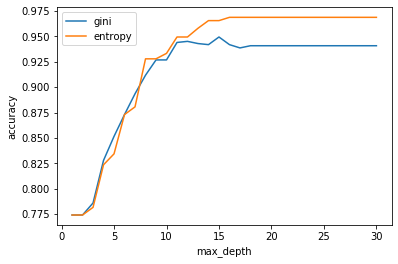

In [16]:
trees = pd.DataFrame({'acc_gini':pd.Series(acc_gini),
                     'acc_entropy':pd.Series(acc_entropy),
                     'max_depth':pd.Series(max_depth)})

plt.plot('max_depth', 'acc_gini', data=trees, label='gini')
plt.plot('max_depth', 'acc_entropy', data=trees, label='entropy')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [17]:
# Train the decision tree using the identified hyperparameters
modelDT = DecisionTreeClassifier(criterion='gini', max_depth=depth, random_state=21)
modelDT.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=16, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=21, splitter='best')

In [18]:
# Use the trained tree to predict the testing data
dt_pred = modelDT.predict(X_test)
dt_pred_prob = modelDT.predict(X_test)

In [19]:
# Run this block for model evaluation 
#from sklearn import metrics
print("Model Metrics")
print("Accuracy:", metrics.accuracy_score(y_test, dt_pred))
print("Balanced accuracy:", metrics.balanced_accuracy_score(y_test, dt_pred))
print('Precision score for "Yes"' , metrics.precision_score(y_test, dt_pred, pos_label = 1))
print('Recall score for "No"' , metrics.recall_score(y_test, dt_pred, pos_label = 0))

Model Metrics
Accuracy: 0.9419354838709677
Balanced accuracy: 0.9492857142857143
Precision score for "Yes" 0.9848484848484849
Recall score for "No" 0.97


In [20]:
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_test, dt_pred))

[[291   9]
 [ 45 585]]


In [21]:
print(classification_report(y_test, dt_pred))

              precision    recall  f1-score   support

       False       0.87      0.97      0.92       300
        True       0.98      0.93      0.96       630

    accuracy                           0.94       930
   macro avg       0.93      0.95      0.94       930
weighted avg       0.95      0.94      0.94       930



In [22]:
importances = modelDT.feature_importances_
#std = np.std([tree.feature_importances_ for tree in modelDF.],axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature UG25abv (0.291112)
2. feature UGDS (0.187222)
3. feature PFTFAC (0.070101)
4. feature ENRL_ORIG_YR4_RT (0.067758)
5. feature NUMBRANCH (0.062231)
6. feature INEXPFTE (0.051633)
7. feature TUITFTE (0.049761)
8. feature RetentionFT (0.042728)
9. feature Complete (0.037653)
10. feature DEBT_MDN (0.037082)
11. feature CONTROL (0.035614)
12. feature COMP_ORIG_YR4_RT (0.031821)
13. feature Cost (0.028998)
14. feature WDRAW_ORIG_YR4_RT (0.006288)
15. feature PREDDEG (0.000000)


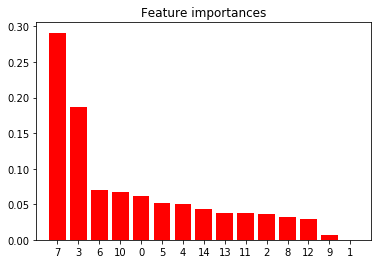

In [23]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r",  align="center") #yerr=std[indices],
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Having higher percentages of older students predicts schools will be open.
Also, having higher enrollment numbers (UGDS) predicts schools will be open.

## AdaBoost model

In [24]:
ABmax_depth = []
score_a = []
score_b = []

for i in range(105, 131, 1):
    atree = AdaBoostClassifier(n_estimators=i, random_state=21)
    atree.fit(X_train, y_train)
    apredict = gtree.predict(X_test)
    score_a.append(metrics.accuracy_score(y_test, apredict))
    ##
    btree = AdaBoostClassifier(modelDT, n_estimators=i, random_state=21)
    btree.fit(X_train, y_train)
    bpredict = btree.predict(X_test)
    score_b.append(metrics.accuracy_score(y_test, bpredict))
    ##
    ABmax_depth.append(i)

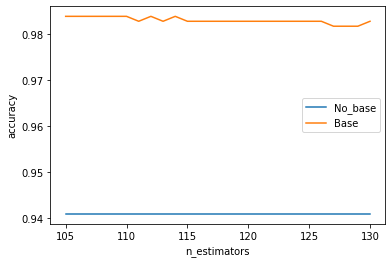

In [25]:
adatrees = pd.DataFrame({'score_a':pd.Series(score_a),
                     'score_b':pd.Series(score_b),
                     'n_estimators':pd.Series(ABmax_depth)})

plt.plot('n_estimators', 'score_a', data=adatrees, label='No_base')
plt.plot('n_estimators', 'score_b', data=adatrees, label='Base')
#plt.vlines(6, 0.895, 0.915)
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [26]:
ideal_estimators = max(score_b)
idx = score_b.index(ideal_estimators)
print(ABmax_depth[idx])

105


In [27]:
modelAB = AdaBoostClassifier(modelDT, n_estimators=ABmax_depth[idx], random_state=21)
modelAB.fit(X_train, y_train)
AB_pred = modelAB.predict(X_test)
print(metrics.accuracy_score(y_test, AB_pred))

0.9838709677419355


In [28]:
print(confusion_matrix(y_test, AB_pred))

[[291   9]
 [  6 624]]


In [29]:
print(classification_report(y_test, AB_pred))

              precision    recall  f1-score   support

       False       0.98      0.97      0.97       300
        True       0.99      0.99      0.99       630

    accuracy                           0.98       930
   macro avg       0.98      0.98      0.98       930
weighted avg       0.98      0.98      0.98       930



In [30]:
importances = modelAB.feature_importances_
std = np.std([tree.feature_importances_ for tree in modelAB.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
names = [X_train.columns[i] for i in indices]

print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, names[f], importances[indices[f]]))

Feature ranking:
1. feature PFTFAC (0.126883)
2. feature UG25abv (0.122125)
3. feature TUITFTE (0.102974)
4. feature UGDS (0.101440)
5. feature Cost (0.082441)
6. feature DEBT_MDN (0.073519)
7. feature COMP_ORIG_YR4_RT (0.071968)
8. feature WDRAW_ORIG_YR4_RT (0.068768)
9. feature RetentionFT (0.061363)
10. feature ENRL_ORIG_YR4_RT (0.056806)
11. feature Complete (0.054580)
12. feature INEXPFTE (0.051448)
13. feature NUMBRANCH (0.023975)
14. feature CONTROL (0.001710)
15. feature PREDDEG (0.000000)


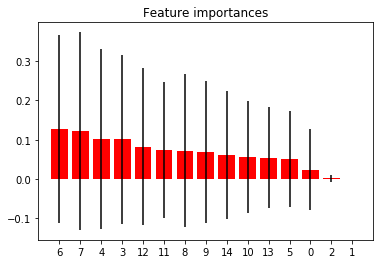

In [31]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

## Exploration of misclassified schools

We are interested in predicting schools that might be in danger of closing. This would be schools that are currently open, but that the model predicts are closed. (These would be the "false negative" cases.) There are 9 schools in this class that could be explored further.

In [32]:
result_dict = {'CURROPER':y_test, 'Predicted':AB_pred}
results = pd.DataFrame(result_dict)
results.head()

,CURROPER,Predicted
74737,True,True
61034,False,False
72888,True,True
52707,False,False
57384,False,False


In [33]:
predicted = pd.concat([X_test, results], axis=1)
predicted.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
74737,1,3,2.0,2432.0,13149.0,6331.0,0.5088,0.1026,0.468582,0.202873,0.023339,23000.0,47341.0,0.5672,0.7496,True,True
61034,78,3,3.0,438.0,12219.0,2704.0,0.0684,0.7945,0.201995,0.447498,0.058573,14847.0,27356.0,0.0963,0.1778,False,False
72888,1,3,1.0,2268.0,3072.0,6352.0,0.6570,0.2040,0.206856,0.269504,0.080378,14000.0,14906.0,0.2439,0.5266,True,True
52707,72,3,3.0,4756.0,11632.0,1690.0,0.0772,0.7759,0.227174,0.436289,0.064302,10677.0,30374.0,0.1042,0.4444,False,False
57384,1,3,2.0,203.0,17897.0,6339.0,1.0000,0.1143,0.500000,0.266667,0.000000,21250.0,32078.0,0.4474,0.8519,False,False


In [34]:
false_pos = predicted.loc[(predicted.Predicted == True) & (predicted.CURROPER == False)]
false_pos.shape

(9, 17)

In [35]:
false_neg = predicted.loc[(predicted.Predicted==False) & (predicted.CURROPER==True)]
false_neg.shape

(6, 17)

In [36]:
false_neg.head(9)
#false_neg.index

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,ENRL_ORIG_YR4_RT,DEBT_MDN,Cost,Complete,RetentionFT,CURROPER,Predicted
76324,31,3,3.0,150.0,7459.0,852.0,0.1507,0.7021,0.134772,0.373141,0.074580,10490.5,28115.0,0.0000,0.3333,True,False
77281,3,3,2.0,82.0,9452.0,3314.0,0.6744,0.7561,0.124167,0.140000,0.240833,11000.0,22784.0,0.0000,0.0000,True,False
76840,71,3,3.0,20.0,12218.0,3732.0,0.4118,0.8500,0.188030,0.464499,0.038686,18532.0,23434.0,0.0870,1.0000,True,False
76943,99,3,3.0,254.0,16479.0,1661.0,0.1304,0.8588,0.112562,0.486724,0.052962,12500.0,28115.0,0.2629,0.0000,True,False
78174,26,3,3.0,130.0,17233.0,3100.0,0.0000,0.8385,0.151715,0.488574,0.030959,20309.5,27517.0,0.5000,0.2857,True,False
77090,99,3,3.0,578.0,15744.0,2171.0,0.2182,0.8397,0.112562,0.486724,0.052962,12500.0,32554.0,0.2629,0.3333,True,False


In [37]:
false_neg_names = false_neg.join(data, how = 'left', lsuffix='_FN')
false_neg_names['INSTNM']

76324    national american university-ellsworth afb ext...
76840        university of phoenix-fairfield county campus
76943                          strayer university-delaware
77090                        strayer university-new jersey
77281        polytechnic university of puerto rico-orlando
78174                            devry university-oklahoma
Name: INSTNM, dtype: object

## Generate graphs for the report

In [38]:
predicted['Result'] = np.nan
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==True), 'Result'] = 'TP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==False), 'Result'] = 'TN'
predicted.loc[(predicted.Predicted==True)&(predicted.CURROPER==False), 'Result'] = 'FP'
predicted.loc[(predicted.Predicted==False)&(predicted.CURROPER==True), 'Result'] = 'FN'
#print(predicted.Result)

In [39]:
to_graph = pd.merge(predicted, data)
to_graph.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
0,1,3,2.0,2432.0,13149.0,6331.0,0.5088,0.1026,0.468582,0.202873,...,0.6349,7147.0,0.6959,2013,26560.0,xl,highest,high,high,NaN
1,78,3,3.0,438.0,12219.0,2704.0,0.0684,0.7945,0.201995,0.447498,...,NaN,1452.0,0.6575,2011,22484.0,medium,highest,med,low,NaN
2,78,3,3.0,438.0,12219.0,2704.0,0.0684,0.7945,0.201995,0.447498,...,NaN,1452.0,0.6575,2011,22484.0,medium,highest,med,low,NaN
3,78,3,3.0,438.0,12219.0,2704.0,0.0684,0.7945,0.201995,0.447498,...,NaN,1452.0,0.6575,2011,22484.0,medium,highest,med,low,NaN
4,78,3,3.0,438.0,12219.0,2704.0,0.0684,0.7945,0.201995,0.447498,...,NaN,1452.0,0.6575,2011,22484.0,medium,highest,med,low,NaN


In [40]:
to_graph.CONTROL = to_graph.CONTROL.astype('str')
to_graph.CONTROL.loc[to_graph.CONTROL == '1.0'] = 'Public'
to_graph.CONTROL.loc[to_graph.CONTROL == '2.0'] = 'NonProfit'
to_graph.CONTROL.loc[to_graph.CONTROL == '3.0'] = 'ForProfit'

to_graph.PREDDEG = to_graph.PREDDEG.astype('str')
#to_graph.drop(['EnrollmentBins', 'TuitionBins', 'ExpenditureBins', 'FacultyBins'], axis=1, inplace=True)
to_graph.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2165 entries, 0 to 2164
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   NUMBRANCH          2165 non-null   int64  
 1   PREDDEG            2165 non-null   object 
 2   CONTROL            2165 non-null   object 
 3   UGDS               2165 non-null   float64
 4   TUITFTE            2165 non-null   float64
 5   INEXPFTE           2165 non-null   float64
 6   PFTFAC             2165 non-null   float64
 7   UG25abv            2165 non-null   float64
 8   COMP_ORIG_YR4_RT   2165 non-null   float64
 9   WDRAW_ORIG_YR4_RT  2165 non-null   float64
 10  ENRL_ORIG_YR4_RT   2165 non-null   float64
 11  DEBT_MDN           2165 non-null   float64
 12  Cost               2165 non-null   float64
 13  Complete           2165 non-null   float64
 14  RetentionFT        2165 non-null   float64
 15  CURROPER           2165 non-null   bool   
 16  Predicted          2165 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [41]:
predControl = to_graph.pivot_table(index='PREDDEG', columns=['CONTROL','Result'], aggfunc='size')
print(predControl)

CONTROL ForProfit             NonProfit               Public     
Result         FN FP   TN  TP        FN  FP   TN   TP     TN   TP
PREDDEG                                                          
3               5  6  892  81         1  13  563  362     61  181


In [42]:
false_neg = to_graph.loc[to_graph.Result == 'FN']
false_neg.head()

,NUMBRANCH,PREDDEG,CONTROL,UGDS,TUITFTE,INEXPFTE,PFTFAC,UG25abv,COMP_ORIG_YR4_RT,WDRAW_ORIG_YR4_RT,...,ADM_RATE,AVGFACSAL,PCTFLOAN,Year,NetPrice,EnrollmentBins,TuitionBins,ExpenditureBins,FacultyBins,RetentionPT
319,31,3,ForProfit,150.0,7459.0,852.0,0.1507,0.7021,0.134772,0.373141,...,NaN,NaN,0.0763,2013,23000.0,small,high,low,NaN,0.2500
1169,3,3,NonProfit,82.0,9452.0,3314.0,0.6744,0.7561,0.124167,0.140000,...,NaN,5560.0,0.6875,2013,18131.0,small,high,med,med,NaN
1338,71,3,ForProfit,20.0,12218.0,3732.0,0.4118,0.8500,0.188030,0.464499,...,NaN,NaN,0.6786,2013,19954.0,small,highest,med,NaN,NaN
1339,99,3,ForProfit,254.0,16479.0,1661.0,0.1304,0.8588,0.112562,0.486724,...,NaN,5992.0,0.8057,2013,23000.0,medium,highest,low,med,0.3077
1513,26,3,ForProfit,130.0,17233.0,3100.0,0.0000,0.8385,0.151715,0.488574,...,0.7931,6250.0,0.7093,2013,23009.0,small,highest,med,high,0.3333


## UGDS - Undergraduate enrollment

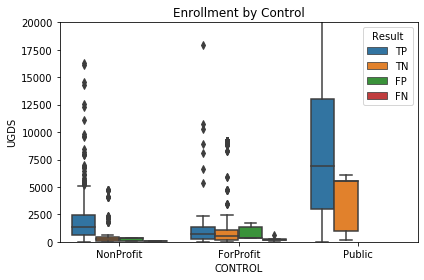

In [43]:
#fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
#plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'UGDS', data = to_graph, hue = 'Result')
plt.ylim(0, 20000)
plt.title('Enrollment by Control')

# plt.subplot(1, 2, 2)
# sns.boxplot('PREDDEG', 'UGDS', data = to_graph, hue = 'Result')
# plt.ylim(0, 10000)
# plt.title('Enrollment by Degree Type')
plt.tight_layout()

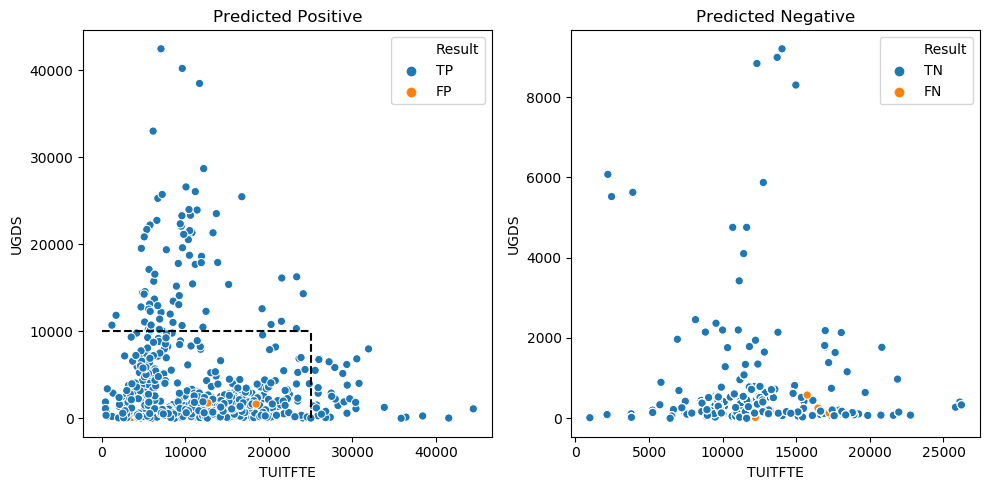

In [44]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
plt.title('Predicted Positive')
plt.hlines(y=10000, xmin=0, xmax=25000, linestyles='dashed')
plt.vlines(x=25000, ymin=0, ymax=10000, linestyles='dashed')
#plt.xlim(0,20000)
#plt.ylim(0,10000)

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
plt.title('Predicted Negative')
#plt.xlim(0,100000)
#plt.ylim(0,40000)
plt.tight_layout()
plt.show()

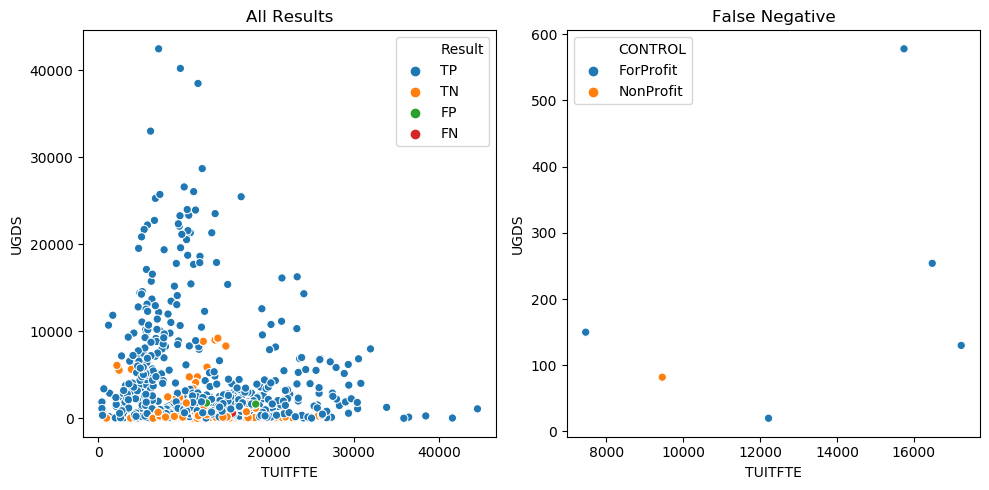

In [45]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All Results')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()
#plt.savefig('figures/SummitxWeekday.png',bbox_inches='tight')

## Tuition and Cost

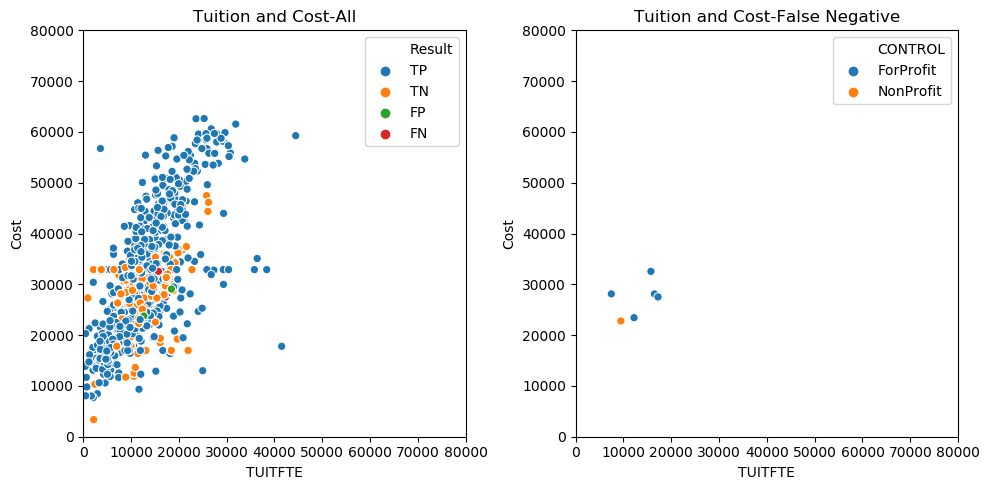

In [46]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph, hue = 'Result')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-All')

plt.subplot(1, 2, 2)
sns.scatterplot('TUITFTE', 'Cost', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.xlim(0, 80000)
plt.ylim(0, 80000)
plt.title('Tuition and Cost-False Negative')
plt.tight_layout()
plt.show()

## Cost and Debt

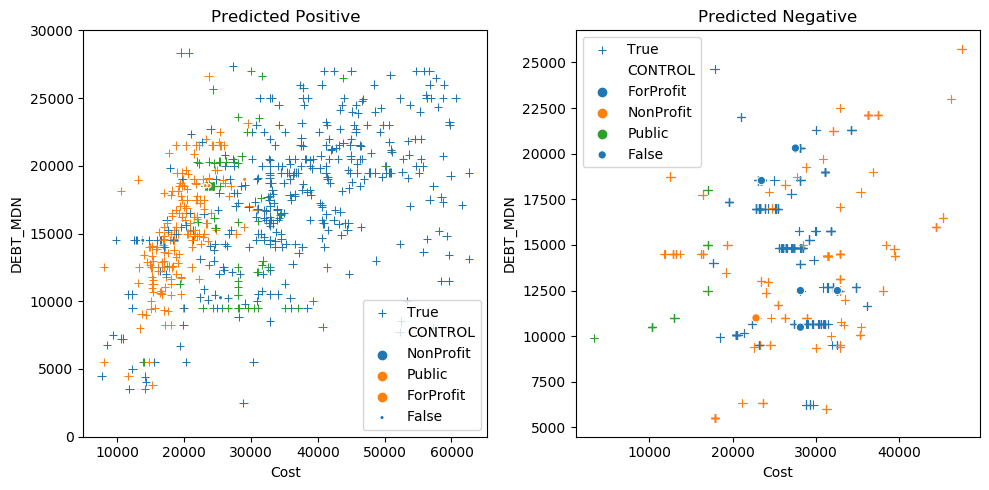

In [47]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Predicted==True], hue='CONTROL')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='.', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Positive')
plt.ylim(0,30000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()

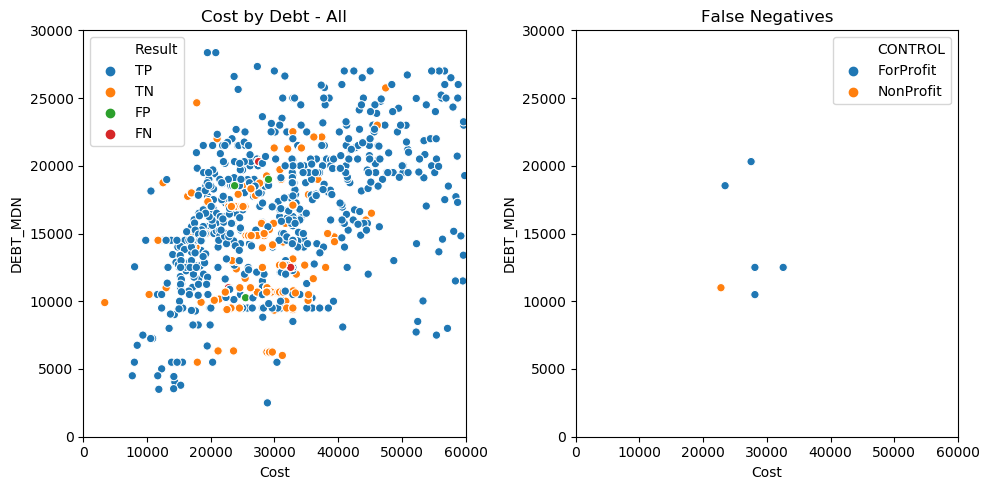

In [48]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph, hue='Result')
plt.title('Cost by Debt - All')
plt.ylim(0,30000)
plt.xlim(0,60000)

plt.subplot(1, 2, 2)
sns.scatterplot('Cost', 'DEBT_MDN', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL')
plt.title('False Negatives')
plt.ylim(0,30000)
plt.xlim(0,60000)
plt.tight_layout()
plt.show()
#plt.savefig('figures/SummitxWeekday.png',bbox_inches='tight')

## NumBranch

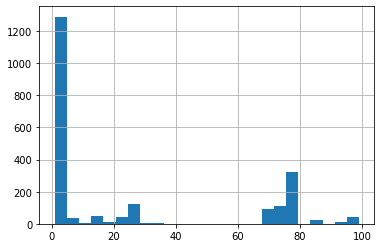

In [49]:
to_graph.NUMBRANCH.hist(bins=25)

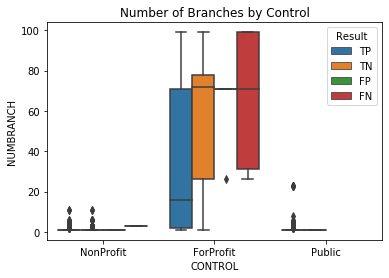

In [50]:
#fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
#plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
plt.title('Number of Branches by Control')

#plt.subplot(1, 2, 2)
#sns.boxplot('PREDDEG', 'NUMBRANCH', data = to_graph, hue = 'Result')
#plt.ylim(0, 100)
#plt.title('Number of Branches by Degree Type')
#plt.tight_layout()
plt.show()

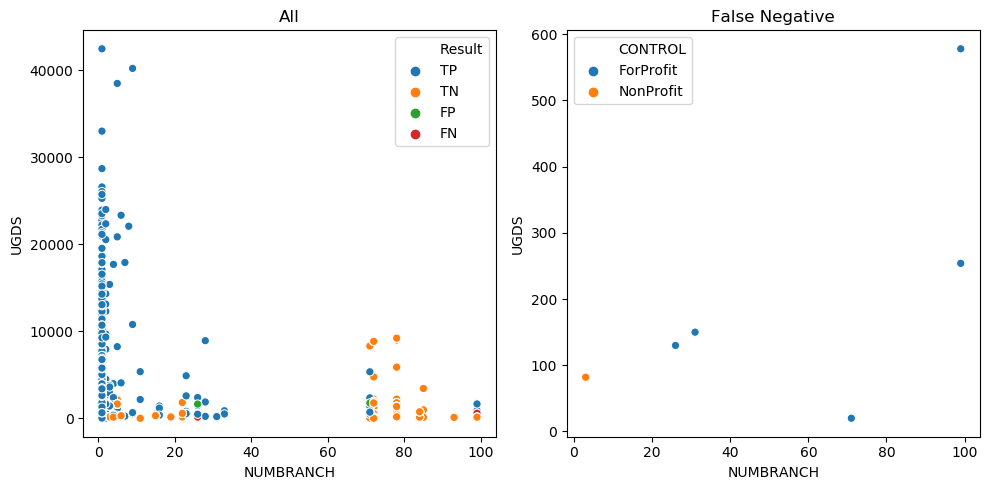

In [51]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph, hue = 'Result')
plt.title('All')

plt.subplot(1, 2, 2)
sns.scatterplot('NUMBRANCH', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
plt.title('False Negative')
plt.tight_layout()
plt.show()

## Instructional Expenditure

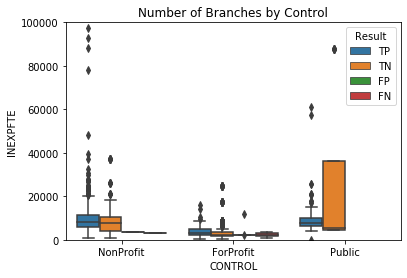

In [52]:
#fig=plt.figure(figsize=(10,4), dpi= 100, facecolor='w', edgecolor='k')
#plt.subplot(1, 2, 1)
sns.boxplot('CONTROL', 'INEXPFTE', data = to_graph, hue = 'Result')
plt.ylim(0, 100000)
plt.title('Number of Branches by Control')

# plt.subplot(1, 2, 2)
# sns.boxplot('PREDDEG', 'INEXPFTE', data = to_graph, hue = 'Result')
# plt.ylim(0, 100000)
# plt.title('Number of Branches by Degree Type')
# plt.tight_layout()
plt.show()

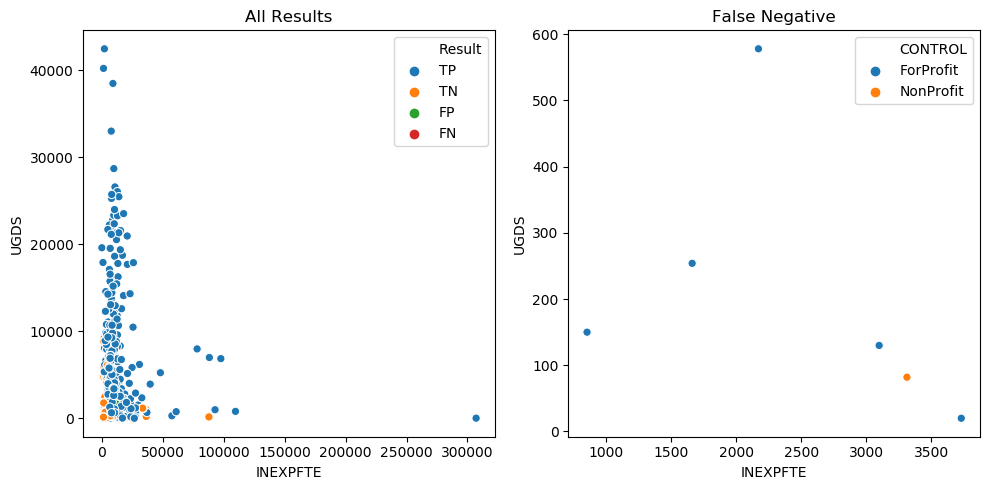

In [53]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph, hue = 'Result')
#plt.xlim(0, 100000)
#plt.ylim(0, 12000)
plt.title('All Results')

plt.subplot(1, 2, 2)
sns.scatterplot('INEXPFTE', 'UGDS', data=to_graph.loc[to_graph.Result=='FN'], hue = 'CONTROL')
#plt.xlim(0, 100000)
#plt.ylim(0, 12000)
plt.title('False Negative')
plt.tight_layout()
plt.show()

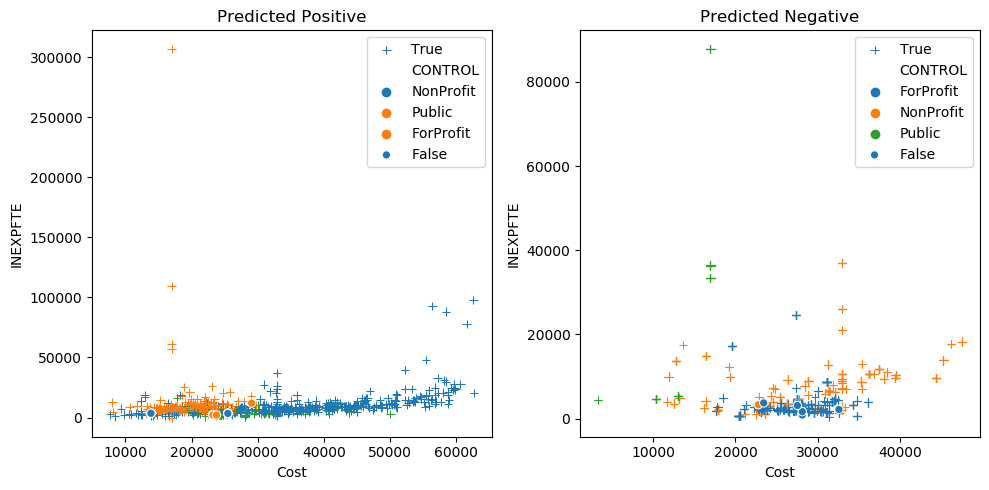

In [54]:
fig=plt.figure(figsize=(10,5), dpi= 100, facecolor='w', edgecolor='k')
plt.subplot(1, 2, 1)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==True], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TP'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FP'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.ylim(0, 50000)
plt.title('Predicted Positive')

plt.subplot(1, 2, 2)
#sns.scatterplot('INEXPFTE', 'Cost', data=to_graph.loc[to_graph.Predicted==False], hue = 'Result')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='TN'], hue='CONTROL', marker='+', label='True')
sns.scatterplot('Cost', 'INEXPFTE', data=to_graph.loc[to_graph.Result=='FN'], hue='CONTROL', marker='o', label='False')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())
#plt.ylim(0, 50000)
plt.title('Predicted Negative')
plt.tight_layout()
plt.show()